In [61]:
import eventDrivenSimulation as eds
import simpy
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import show as sh
import requests
import folium
import haversine
import math
import bibliothek as bib
import random

## Data Generation

In [2]:
CONFIG = {}

CONFIG['LAT'] = 51.34053598409240
CONFIG['LON'] = 12.381419774766130
CONFIG['RADIUS'] = 500
CONFIG['NUM_UES'] = 400
CONFIG['URL'] = 'https://pqos-api-test.radiolab.dit.htwk-leipzig.de' 

In [3]:
def create_sector_shape(lon, lat, dir=0, width=120):
    p = [(lat, lon)]
    n_points = 10
    
    for a in range(n_points):
        p.append(haversine.inverse_haversine(p[0], 0.05, (dir - width/2 + width/n_points*a)/180.0 * math.pi))
    
    p.append(p[0])
    return p

In [4]:
ul_scenario_map = folium.Map(location = [CONFIG['LAT'], CONFIG['LON']], tiles = "cartodbpositron", zoom_start = 15)

ul_query_string = CONFIG['URL'] + '/generate_scenario' + \
                                  '?lat=' + str(CONFIG['LAT']) + \
                                  '&lon=' + str(CONFIG['LON']) + \
                                  '&radius=' + str(CONFIG['RADIUS']) + \
                                  '&num_ues=' + str(CONFIG['NUM_UES']) + \
                                '&cell_type=NGMN3600'

ul_response_data = requests.get(ul_query_string).json()
ue_data = ul_response_data['ue_data']
cell_data=ul_response_data['cell_data']
        
folium.Circle(radius = CONFIG['RADIUS'], 
              location = (CONFIG['LAT'], CONFIG['LON']), 
              color = 'blue', 
              fill_color = 'blue',
              fill_opacity = 0.1,
              fill = True,
              weight = 0,
             ).add_to(ul_scenario_map)            
        
for cell in cell_data:
    cell_color = '#ea0a8e'
        

    folium.PolyLine(
        create_sector_shape(cell['lon'], cell['lat'], cell['az'], 60), 
        color = cell_color,
        fill_color = cell_color,
       fill_opacity = 0.5, 
        fill = True,
        weight = 2,
        #popup = 'RBs: ' + str(cell['ul_rb_requirement']['mean']),
        tooltip = 'PCI: ' + str(cell['pci'])).add_to(ul_scenario_map)
    
    folium.Circle(radius = 10, 
                  location = (cell['lat'], cell['lon']), 
                  color = 'black', 
                  fill_color = 'black',
                  fill_opacity = 1,
                  fill = True,
                  weight = 0,
                  popup = cell['site_name']
                 ).add_to(ul_scenario_map)


display(ul_scenario_map)

In [5]:
df_ue=pd.DataFrame(ue_data)

In [6]:
df_cell = pd.DataFrame(cell_data)

In [7]:
sectors=df_cell['pci'].unique()

In [8]:
bs_dict={}
for i in df_cell.index:
    bs_dict.update({df_cell.loc[i]['pci']:[df_cell.loc[i]['lon'],df_cell.loc[i]['lat']]})

In [9]:
user_dataframe=pd.DataFrame()
x=np.array([])
for i in df_ue['id']:
    dic=df_ue.loc[i]['cell_info']
    powers={}
    pos=df_ue.loc[i]['pos']
    powers.update({'lat':pos[0]})
    powers.update({'lon':pos[1]})
    for i in dic:
        powers.update({i['pci']:i['dl_rx_power']})
    x=np.append(x,powers)
user_dataframe = pd.DataFrame.from_records(x)

## Preprocessing & CoMP Calculations

Settings for the CoMP Calculations: 
* noise power = -104 dBm

P=vector with receiving powers from all PCIs (N)

**SINR without CoMP**: $\frac{P_{0}}{P_{N}+P_{1:N}}$

**SINR with CoMP (2 coord. PCIs)** : $\frac{(\sqrt{P_{0}}+\sqrt{P_{1}})^2}{P_{N}+P_{2:N}}$

In [10]:
noise=np.power(10,-104/10) #https://www.sciencedirect.com/topics/engineering/noise-power -> 10MHz bandwidth (50PRBs)
cluster=sectors #all the cells are put in one cluster

In [43]:
df=user_dataframe.copy()
SINR_list=np.array([])
SINRwithCoMP_list=np.array([])
SINRwithCoMP_phaseshiftList=np.array([])
c_cell=np.array([])
s_cell=np.array([])
for i in np.arange(0, len(df)):
    P=df.loc[i,:][2:] #goes through file line by line and selects the line
    P=np.power(10, P/10) # calculate the linear values for capacity calculations
    P=P.sort_values(ascending=False) # sort values by their order
    A=np.sqrt(P) #calculate the amplitude
    index=P.index.values #Extract all index values 
    index=index.astype(np.int) #PCIen as integer
    A=np.array(A)
    P=np.array(P)
    pci_coord= index[1]
    SINR= P[0]/(np.sum(P[1:])+noise)
    SINRwithCoMP= np.power(np.sum(A[0:2]),2)/(np.sum(P[2:])+noise)
    phi=random.gauss(0, math.pi)
    SINRwithCoMP_phaseshift=10*np.log10((np.power(A[0]+A[1]*np.cos(phi),2)+np.power(A[1]*np.sin(phi),2))/(np.sum(P[2:])+noise))
    
    SINR_list=np.append(SINR_list,10*np.log10(SINR)) #appends the calculated elements
    SINRwithCoMP_list=np.append(SINRwithCoMP_list,10*np.log10(SINR_CoMP))
    SINRwithCoMP_phaseshiftList=np.append(SINRwithCoMP_phaseshiftList,SINRwithCoMP_phaseshift)

    s_cell=np.append(s_cell,index[0])
    c_cell=np.append(c_cell,index[1])

##### Building the dataframe

In [44]:
df['lat']=user_dataframe['lat']
df['lon']=user_dataframe['lon']
df['SINR [dB]']=SINR_list
df['SINR-CoMP [dB]']=SINRwithCoMP_list
df['SINR-CoMP with phaseshift [dB]']=SINRwithCoMP_phaseshiftList
df['PCI Serving']=s_cell.astype(int)
df['PCI Coord']=c_cell.astype(int)
df['qos']=np.zeros(len(user_dataframe)) #not needed here -> all users are best effort -> 0
df['id']=np.arange(0,len(user_dataframe))

#### Define general parameters for the simulation

In [47]:
max_prb=50 #number of prbs defined by the system bandwidth
ue_nr=15 #number of ues per pci
metric=[1,1] #defines the exponents of the metric (standard metric is pf ->[1,1])

#### Sort out PCIs that have less than ue_nr users -> edge of the Scenario

In [48]:
#check if the number of users (positions) for the serving pci is >10
df_filter=df.groupby('PCI Serving')
count=0
for i in df['PCI Serving'].unique():
    k=df_filter.get_group(i)
    if(len(k)<ue_nr):
        cluster=np.delete(cluster,count) #delete cells with less than 10 positions
        df=df[df['PCI Serving']!=i]
    count+=1

#### Define a cluster

In [49]:
sectors= np.array(df['PCI Serving'].unique())
print('pci options for cluster:',sectors)

pci options for cluster: [774 775 776 132 319 318 133 134]


In [54]:
#cluster=[134,776,319]
cluster=[133,775]
#cluster=sectors
#cluster=[133,775,319]

if following code says "sinr out of range" thats because the sinr is just restricted up to 30 dB

In [55]:
index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

size=4000 #size of each packets that arrives from a user (Bit)
env=simpy.Environment()

#ues are initialized 
ue_dict=eds.df_to_ue_lists(df,cluster,6,env) #ue_dict is dict with all users from the dataframe from the defined cluster

# select only ue_nr of users from given index 
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

## Analysis for mu = 4ms (av. packet arrival time)

timer=2000 
8 sectors in one cluster -> T=26s
2 sectors in one cluster -> T=6s

In [56]:
#r='random' 
r='deterministic'

mu=4
env=simpy.Environment()
sched_l=[]
sched3=eds.sched_inst(env)
for i in cluster:
    sched1=eds.sched_inst(env)
    sched_l.append(eds.sched_inst(env))

index=np.zeros([len(cluster),ue_nr])
for i in np.arange(0,len(cluster)):
    index[i,:]=np.arange(0,ue_nr)
index=index.astype(int)

ue_dict=eds.df_to_ue_lists(df,cluster,6,env)
if(r=='random'):
    counter=0
    for i in cluster:
        index[counter]=random.sample(list(np.arange(1,len(ue_dict[i]))),ue_nr)
        counter+=1    
ue_per_pci,ue_all=eds.get_user_from_cluster(ue_dict,cluster,ue_nr,index)

prb_number_comp=eds.calculate_prb_number_comp(ue_all,cluster,max_prb,ue_nr)

env=simpy.Environment()

SCHEDULE_T=2 #Clock of scheduler -> every 2ms

SCHEDULE_T=2 #Clock des Schedulers 
for i in cluster:
    ue_list=ue_per_pci[i]
    for j in ue_list:
        env.process(j.best_effort_stat(env,mu))
    

ue_comp=np.array([]) #ues that use comp -> processed by central_scheduler
for i in cluster:
    ue_list=ue_per_pci[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp

env.process(sched3.central_scheduler(env,ue_comp,SCHEDULE_T,cluster,prb_number_comp,metric))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    prb_number_normal=max_prb-prb_number_comp[i]
    env.process(sched_l[counter].scheduler(env,ue_sep,SCHEDULE_T,cluster,max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
timer=2000
env.run(until=timer)

C:\Users\Caroline Zoll\EDS\eds_clustering.py:192: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds_clustering.py:222: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


### Graph Visualization
Choose between two modes -> comp-gain shows a color plot for the gain with comp & user-assignment shows which users are assigned to which pci

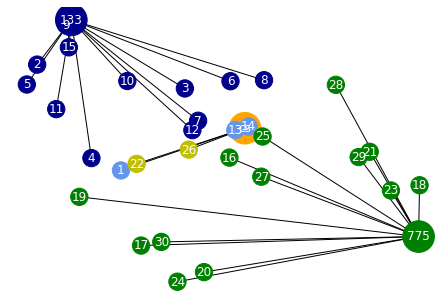

In [59]:
import plotly.graph_objects as go
import networkx as nx

mode='user-assignment'
#mode='comp-gain'

df2 = pd.read_json("Prepro/cell_data.txt")
BS_pos={}
for i in cluster:
    BS_pos.update({i: bs_dict[i]})

G=nx.Graph()

x=np.arange(1,ue_nr*len(cluster))
G.add_node('cs')
for i in cluster:
    G.add_node(str(i))

BS_pos={}
for i in cluster:
    BS_pos.update({i: bs_dict[i]})

loc_list=np.array(list(BS_pos.values()))
loc_dic={}
loc_dic['cs']=[loc_list[:,0].mean(),loc_list[:,1].mean()]

for i in cluster:
    loc_dic[str(i)]=BS_pos[i]

G.add_nodes_from(x)

#n_c=np.array(['orange','darkblue','green'])
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
       # if(i.cell1==cluster[0]):
        #    n_c=np.append(n_c,'cornflowerblue')
        #elif(i.cell1==cluster[1]):
         #   n_c=np.append(n_c,'y')
    else:
        for j in cluster:
            if(i.cell1==j):
                G.add_edge(counter,str(j))
    counter+=1

n_c=np.array(['orange'])
color_selection_bs=['darkblue','green','purple','black','darkred']
color_selection_user=['cornflowerblue','y','plum','gray','red']
if(len(cluster) > len(color_selection_bs)):
    color_selection_bs=[]
    color_selection_user=[]
    for i in cluster:
        color_selection_bs.append('darkblue')
        color_selection_user.append('cornflowerblue')
n_c=np.append(n_c,color_selection_bs[0:len(cluster)])
color_edge_ues = dict(zip(cluster,color_selection_user[0:len(cluster)]))    
color_bs=dict(zip(cluster,color_selection_bs[0:len(cluster)]))  
counter=1
for i in ue_all:
    loc_dic.update({counter:[i.y,i.x]})
    if(i.comp==1):
        G.add_edge(counter,'cs')
        for j in cluster:
            if(i.cell1==j):
                n_c=np.append(n_c,color_edge_ues[j])        
    else:
        for j in cluster:
            if(i.cell1==j):
                G.add_edge(counter,str(j))
                n_c=np.append(n_c,color_bs[j])
    counter+=1
        
n_s=np.ones(ue_nr*len(cluster)+1+len(cluster))*300
n_s[0:(1+len(cluster))]=1000

m=np.array([])
m=np.append(m,np.ones(len(cluster)+1))
t=np.array([])
t=np.append(t,np.ones(len(cluster)+1))
for i in ue_all:
    m=np.append(m,(i.mR2/i.mR))
    if(i.comp==1):
        t=np.append(t,i.tbs2)
    else:
        t=np.append(t,i.tbs)
m[len(cluster):]=10*np.log10(m[len(cluster):])
vmin = np.min(m)
vmax = np.max(m)
m[0:len(cluster)]=np.mean(m[len(cluster):])

if(mode=='user-assignment'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=n_c,font_color='white',node_size=n_s)
elif(mode=='comp-gain'):
    nx.draw(G,pos=loc_dic,with_labels=True,node_color=m,font_color='white',node_size=n_s,cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    x=plt.colorbar(sm)
    x.set_label('CoMP gain in [dB]', rotation=270,labelpad=20)

plt.draw()
plt.show()

## Numerical Results

In [20]:
df_res=eds.ue_to_df(ue_all)
df1=df_res[df_res['pci 1']==cluster[0]]
df2=df_res[df_res['pci 1']==cluster[1]]

for i in cluster:
    df3=df_res[df_res['pci 1']==i]
    print('average comp gain pci '+str(i)+': '+str((df3['mR gain'].mean()-1)*100)+'%')
print('average comp gain: '+str(round(((df1['mR gain'].mean()+df2['mR gain'].mean())/2-1)*100))+'%')

average comp gain pci 134: 4.456264847314428%
average comp gain pci 776: 0.6835065500281123%
average comp gain pci 132: 9.007414075445075%
average comp gain pci 319: 20.331653822953434%
average comp gain pci 774: -12.020839350657075%
average comp gain pci 318: 23.00555979276473%
average comp gain pci 133: -1.2828596498447364%
average comp gain pci 775: 49.37177919582765%
average comp gain: 3%


In [21]:
comp_user=df_res[df_res['comp']==1]
df_nc=df_res[df_res['comp']==0]

all ues
10% Quantil: -22.94420943323034
90% Quantil: 100.10742800401408
50% Quantil (Median): -14.169269187812699
comp ues
10% Quantil: 22.81397266645547
90% Quantil: 169.17458340566378
50% Quantil (Median): 87.90597696176287
no_comp ues
10% Quantil: -37.90814038839001
90% Quantil: -5.883644429501917
50% Quantil (Median): -21.63713808269767


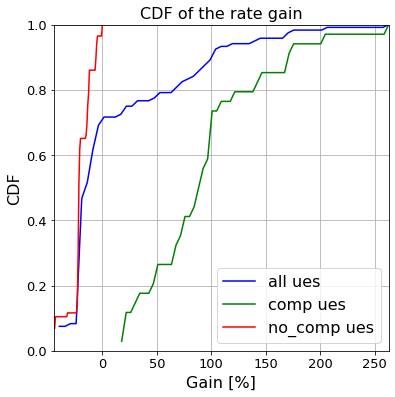

In [22]:
x=(df_res['mR gain']-1)*100
y=(comp_user['mR gain']-1)*100
z=(df_nc['mR gain']-1)*100
sh.cdf_3(x,'all ues','blue',y,'comp ues','green',z,'no_comp ues','red','CDF of the rate gain',min(x),max(x),'Gain [%]',60)